---
layout: post
title:  "Forward Modelling for Supernova Cosmology"
desc: "A toy model implementation"
date: 2020-04-08
categories: [tutorial]
tags: [statistics]
loc: 'tutorials/forwardmodelling/'
permalink: /tutorials/forwardmodelling
math: true
---

!!!replace

So in this example, I'm simply trying to demonstrate the viability of forward models with supernova cosmology. In this, I'll be simplifying a lot, and in this case, ignoring proper treatment of uncertainty contributions from Monte-Carlo uncertainty. We'll start with a simple model in which simulated supernova have redshift, magnitude and colour, apply selection effects, and ensure that we can recover input cosmology without having to resimulate by exploiting the fact that our selection effects operate in the observer frame of reference.



In [47]:
# Remove
import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
plt.rcParams["axes.labelsize"] = 14
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = (cycler(color=['#48AB75',  '#5BC0EB', '#E55934', '#FA7921', '#ced9ed', '#fff29b']) + cycler(linestyle=['-', '-', ':', '-.', '-', '--']))

## Generating Data

First things first - lets generate some random data in a horrifically simplified toy model.

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, uniform
from astropy.cosmology import FlatLambdaCDM
from scipy.stats import binned_statistic
np.random.seed(0)

def get_fake_dist(loc=0, scale=1, size=1):
    """ To make sure we dont need a suite of tests, 
    fake sampling a normal so that it is symmetric"""
    cdfs = norm.cdf(norm.rvs(size=size))
    maxv = min(cdfs.max(), 0.999)
    vals = norm.ppf(np.linspace(1 - maxv, maxv, size)) * scale + loc
    np.random.shuffle(vals)
    return vals

In [38]:
def get_events(om=0.3, MB=-19.3, sigma_int=0.1, mean_c=0, 
               sigma_c=0.1, beta=3.1, num=5000):
    zs = np.linspace(0.05, 1.05, num)   
    
    # I sample bit by bit in redshift space to make sure our posterior 
    # should be centered roughly on the true value, otherwise we'd have 
    # to run a suite of realisations to test the statistics rigorously.
    bins = 100
    n = int(num / bins)
    deltas = np.array([])
    cs = np.array([])
    for i in range(bins):
        deltas = np.concatenate((deltas, get_fake_dist(scale=sigma_int, size=n)))
        cs = np.concatenate((cs, get_fake_dist(loc=mean_c, scale=sigma_c, size=n)))

    MBs = MB + deltas + beta * cs
    distmod = FlatLambdaCDM(70, om).distmod(zs).value
    mb = distmod + MBs
    # Emulate some probabilistic selection effect
    mask = (mb + norm.rvs(scale=0.3, size=num)) < 24
    return mb[mask], zs[mask], cs[mask]

data_mbs, data_zs, data_cs = get_events()

Now, let's plot our generated data to make sure it all looks good.

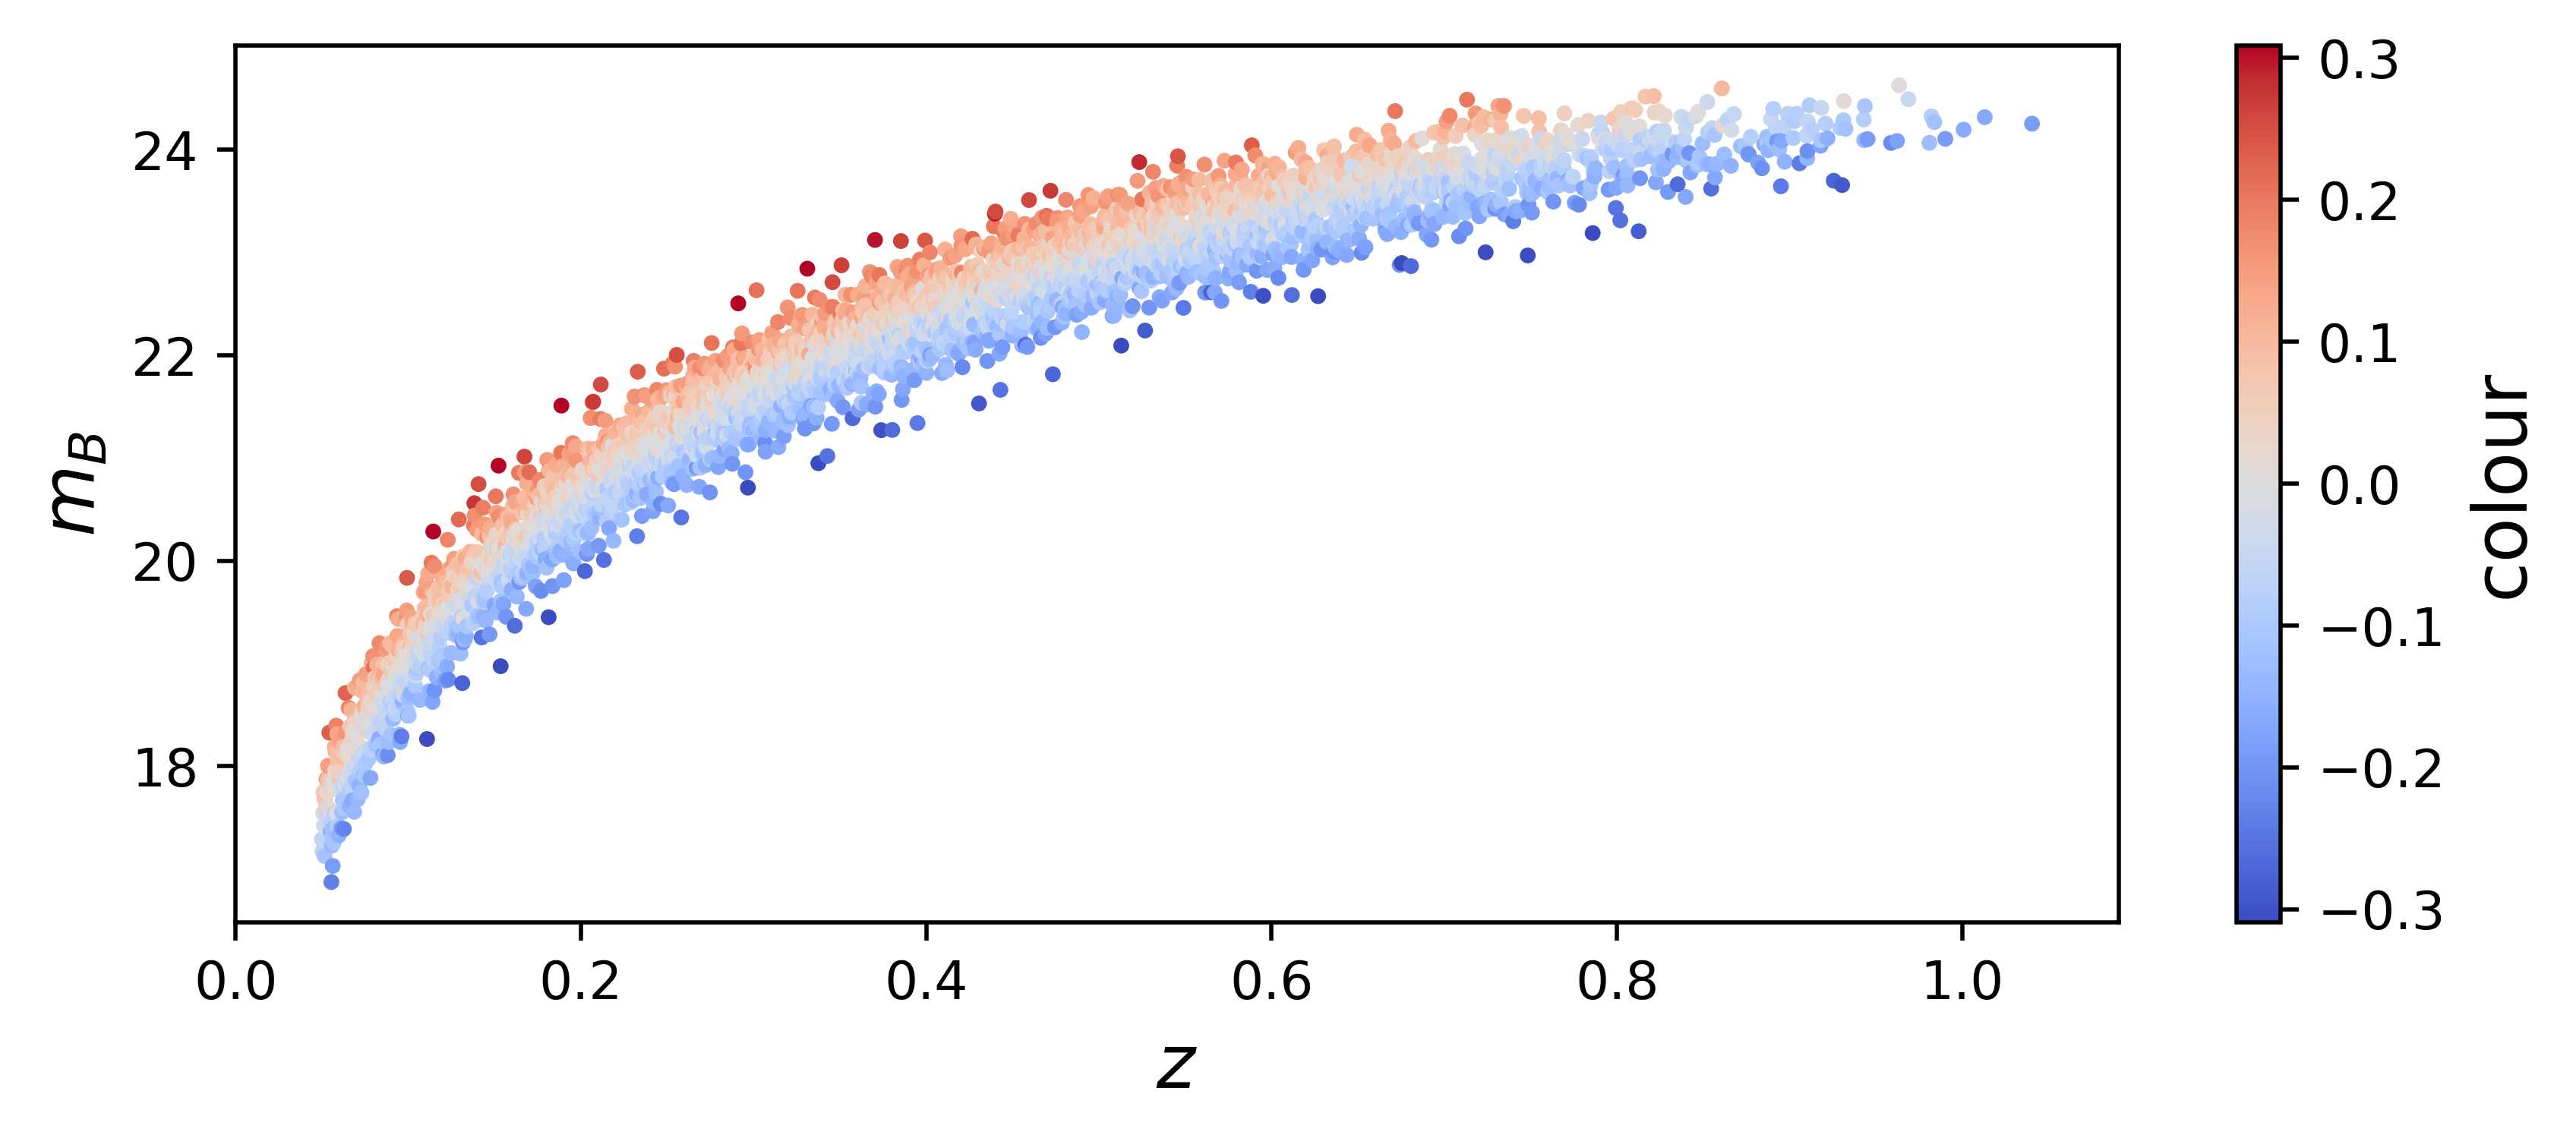

In [48]:
fig, ax = plt.subplots(figsize=(8,3))
h = ax.scatter(data_zs, data_mbs, c=data_cs, cmap="coolwarm")
plt.colorbar(h).set_label("colour"), ax.set_xlabel("$z$"), ax.set_ylabel("$m_B$");

!!!main


Great, so we have "data". If we want to fit it using some importance-sampling ABC method we need to:

1. Create a base simulation
2. Reweight the simulation base on top-level parameters like Om, MB, sigma_int.
3. Compare the data to the re-weighted simulation to get a likelihood.

In [4]:
def get_sim_events(num=100000):
    MBs = uniform.rvs(-21.3, 4, size=num)
    cs = uniform.rvs(-0.5, 1, size=num)
    betas = uniform.rvs(2, 4.5, size=num)
    zs = 0.05 + uniform.rvs(size=num)
    # The value here for om doesnt actually matter
    distmod = FlatLambdaCDM(70, 0.3).distmod(zs).value
    mb = distmod + MBs + betas * cs
    # Emulate some probabilistic selection effect
    mask = (mb + norm.rvs(scale=0.3, size=num)) < 24
    return mb[mask], zs[mask], betas[mask], cs[mask]

sim_mbs, sim_zs, sim_betas, sim_cs = get_sim_events()

Lets check the spread of this broad simulation.

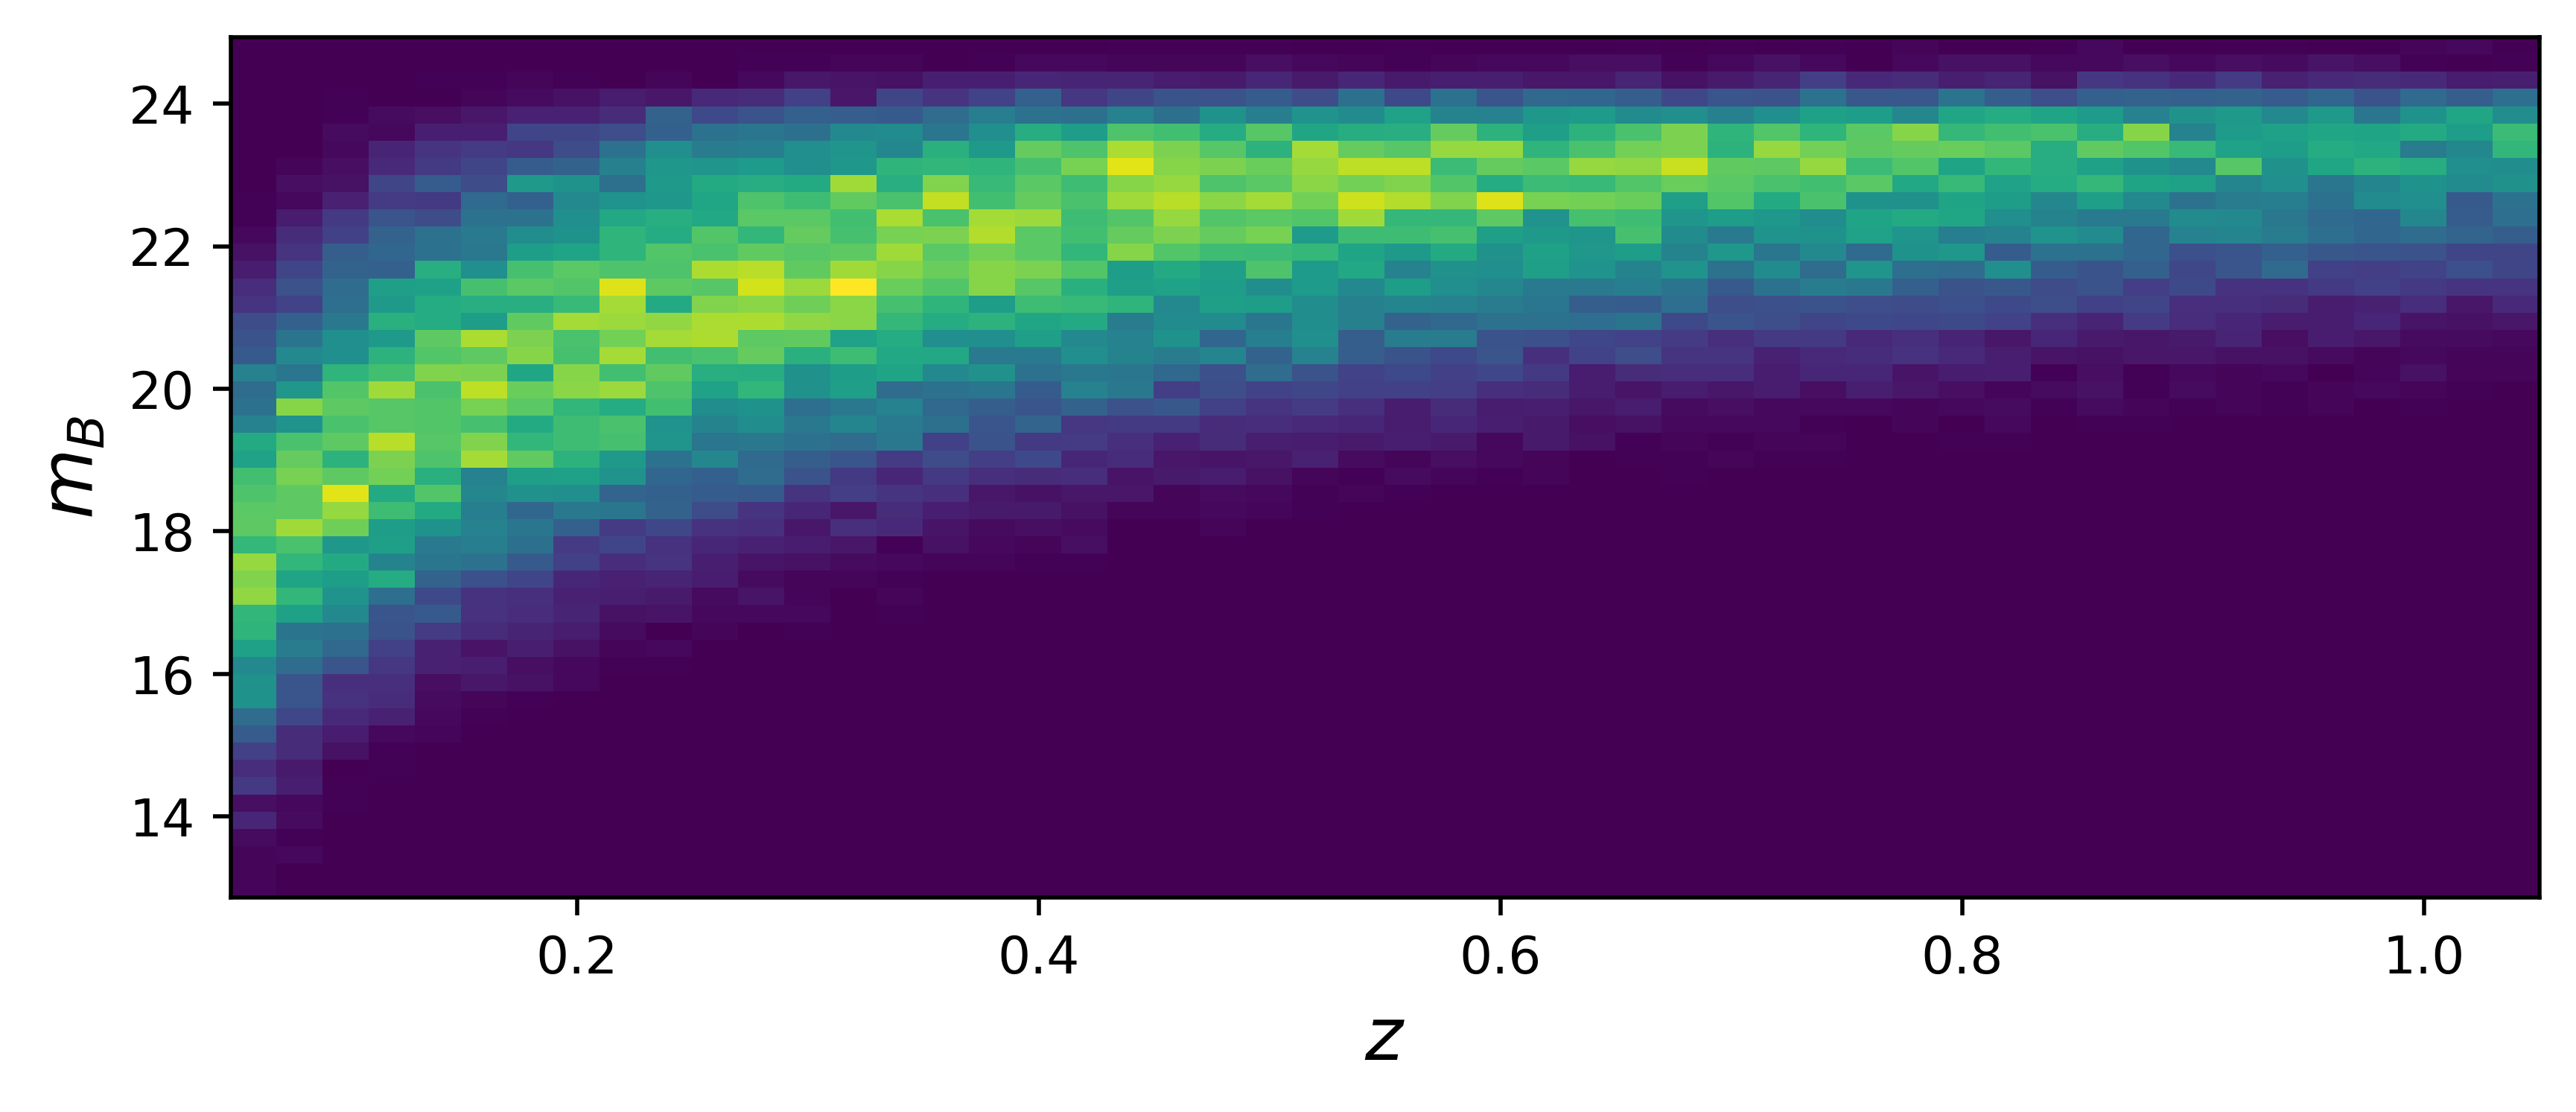

In [49]:
fig, ax = plt.subplots(figsize=(8,3))
ax.hist2d(sim_zs, sim_mbs, bins=50)
ax.set_xlabel("$z$"), ax.set_ylabel("$m_B$");

Hopefully, its broad enough. Now to reweight the simulation based on the top-level parameters.

In [6]:
def reweight(sim_mbs, sim_zs, sim_cs, om, MB, sigma_int, mean_c, sigma_c, beta):
    # Step 1: Use om to move from observer frame to rest frame
    distmod = FlatLambdaCDM(70, om).distmod(sim_zs).value
    sim_MBs = sim_mbs - distmod - beta * sim_cs
    
    # Use top-level parameters to get pdf of simulation points
    weights = norm.logpdf(sim_MBs, MB, sigma_int) + norm.logpdf(sim_cs, mean_c, sigma_c)
    return np.exp(weights)

Right, so we've got this, but it would be good if we could actually do some MCMC on this bad boy. Let's make a likelihood function. For simplicity in this notebook I'm going to break scope.

In [7]:
# Define some histogram edges
mb_edges = np.linspace(13, 26, 31), 
z_edges = np.linspace(0.05, 1.05, 31)
c_edges = np.linspace(-0.5, 0.5, 11)
mbc, zc, cc = 0.5 * (mb_edges[:-1] + mb_edges[1:])
zc = 0.5 * (z_edges[:-1] + z_edges[1:])
cc = 0.5 * (c_edges[:-1] + c_edges[1:])
bins = [mb_edges, z_edges, c_edges]
data = np.vstack((data_mbs, data_zs, data_cs)).T
print(data.shape)

(3476, 3)


So 3476 supernova in our little "data" sample, for each event we have the apparent magnitude, redshift and colour. Lets now bin these up.

In [8]:
thresh = 2  # If you dont have more than 2 samples, dont count it
hist, _ = np.histogramdd(data, bins=[mb_edges, z_edges, c_edges])
delta_vol = np.diff(mb_edges)[0] * np.diff(z_edges)[0] * np.diff(c_edges)[0]
volume = hist.sum() * delta_vol
hist_err = np.sqrt(hist)
hist_err[hist_err < thresh] = np.inf

hist_err = hist_err / volume
hist = hist / volume


And after binning the data, we need to now bin the simulations on the same grid.

In [ ]:
sim = np.vstack((sim_mbs, sim_zs, sim_cs)).T
sim_count, _ = np.histogramdd(sim, bins=[mb_edges, z_edges, c_edges])
sim_num_err = np.sqrt(sim_count)
sim_num_err[sim_num_err < thresh] = np.inf
sim_err_ratio = sim_num_err / sim_count
sim_err_ratio[sim_count == 0] = np.inf

And we'll now add in functions to compute the $\chi^2$ value, and the log posterior as well (I'm nastily just hacking in parameter bounds that are just flat priors).

In [35]:
def get_chi2(x, plot=False):
    om, MB, sigma_int, mean_c, sigma_c, beta = x
    # Add a prior onto MB to help fitting

    weights = reweight(sim_mbs, sim_zs, sim_cs, om, MB, sigma_int, mean_c, sigma_c, beta)
    # Now need a likelihood combining data and simulation. This is super simple, we'd probably 
    # want something like 1712.01293 in a real analysis where we combine MC and Poisson uncert.
    sim_hist, _ = np.histogramdd(sim, bins=bins, weights=weights, density=True)
    sim_err = sim_hist * sim_err_ratio
    chi2 = ((sim_hist - hist)**2 / (hist_err**2 + sim_err**2))
    chi2 = np.nan_to_num(chi2, copy=False).sum()
    return chi2

def get_log_posterior(x):
    om, MB, sigma_int, mean_c, sigma_c, beta = x
    bounds = [(0.05, 0.5), (-21.3, -17.3), (0, 1), (-0.3, 0.3), (0, 0.5), (2, 4.5)]
    for p, (minv, maxv) in zip(x, bounds):
        if not minv < p < maxv:
            return -np.inf
    prior = norm.logpdf(MB, -19.3, 1)
    val = -0.5 * get_chi2(x) + prior
    if np.isnan(val):
        return -np.inf
    return val

Lets check a simple minimisation over a grid to ensure things look alright before shipping it off to sample.

In [17]:
test_oms, test_MBs = np.meshgrid(np.linspace(0.1, 0.7, 30), np.linspace(-19.3-1, -19.3+1, 30))
test_oms_flat, test_MBs_flat = test_oms.flatten(), test_MBs.flatten()
test_sigma_int = test_sigma_c = np.ones(test_oms.size) * 0.1
test_mean_c = test_sigma_c * 0
test_beta = np.ones(test_oms.size) * 3.1

# Generate points with varying Om and MB only
xs = np.vstack((test_oms_flat, test_MBs_flat, test_sigma_int, 
                test_mean_c, test_sigma_c, test_beta)).T
chi2s = np.array([get_chi2(x) for x in xs]).reshape(test_oms.shape)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


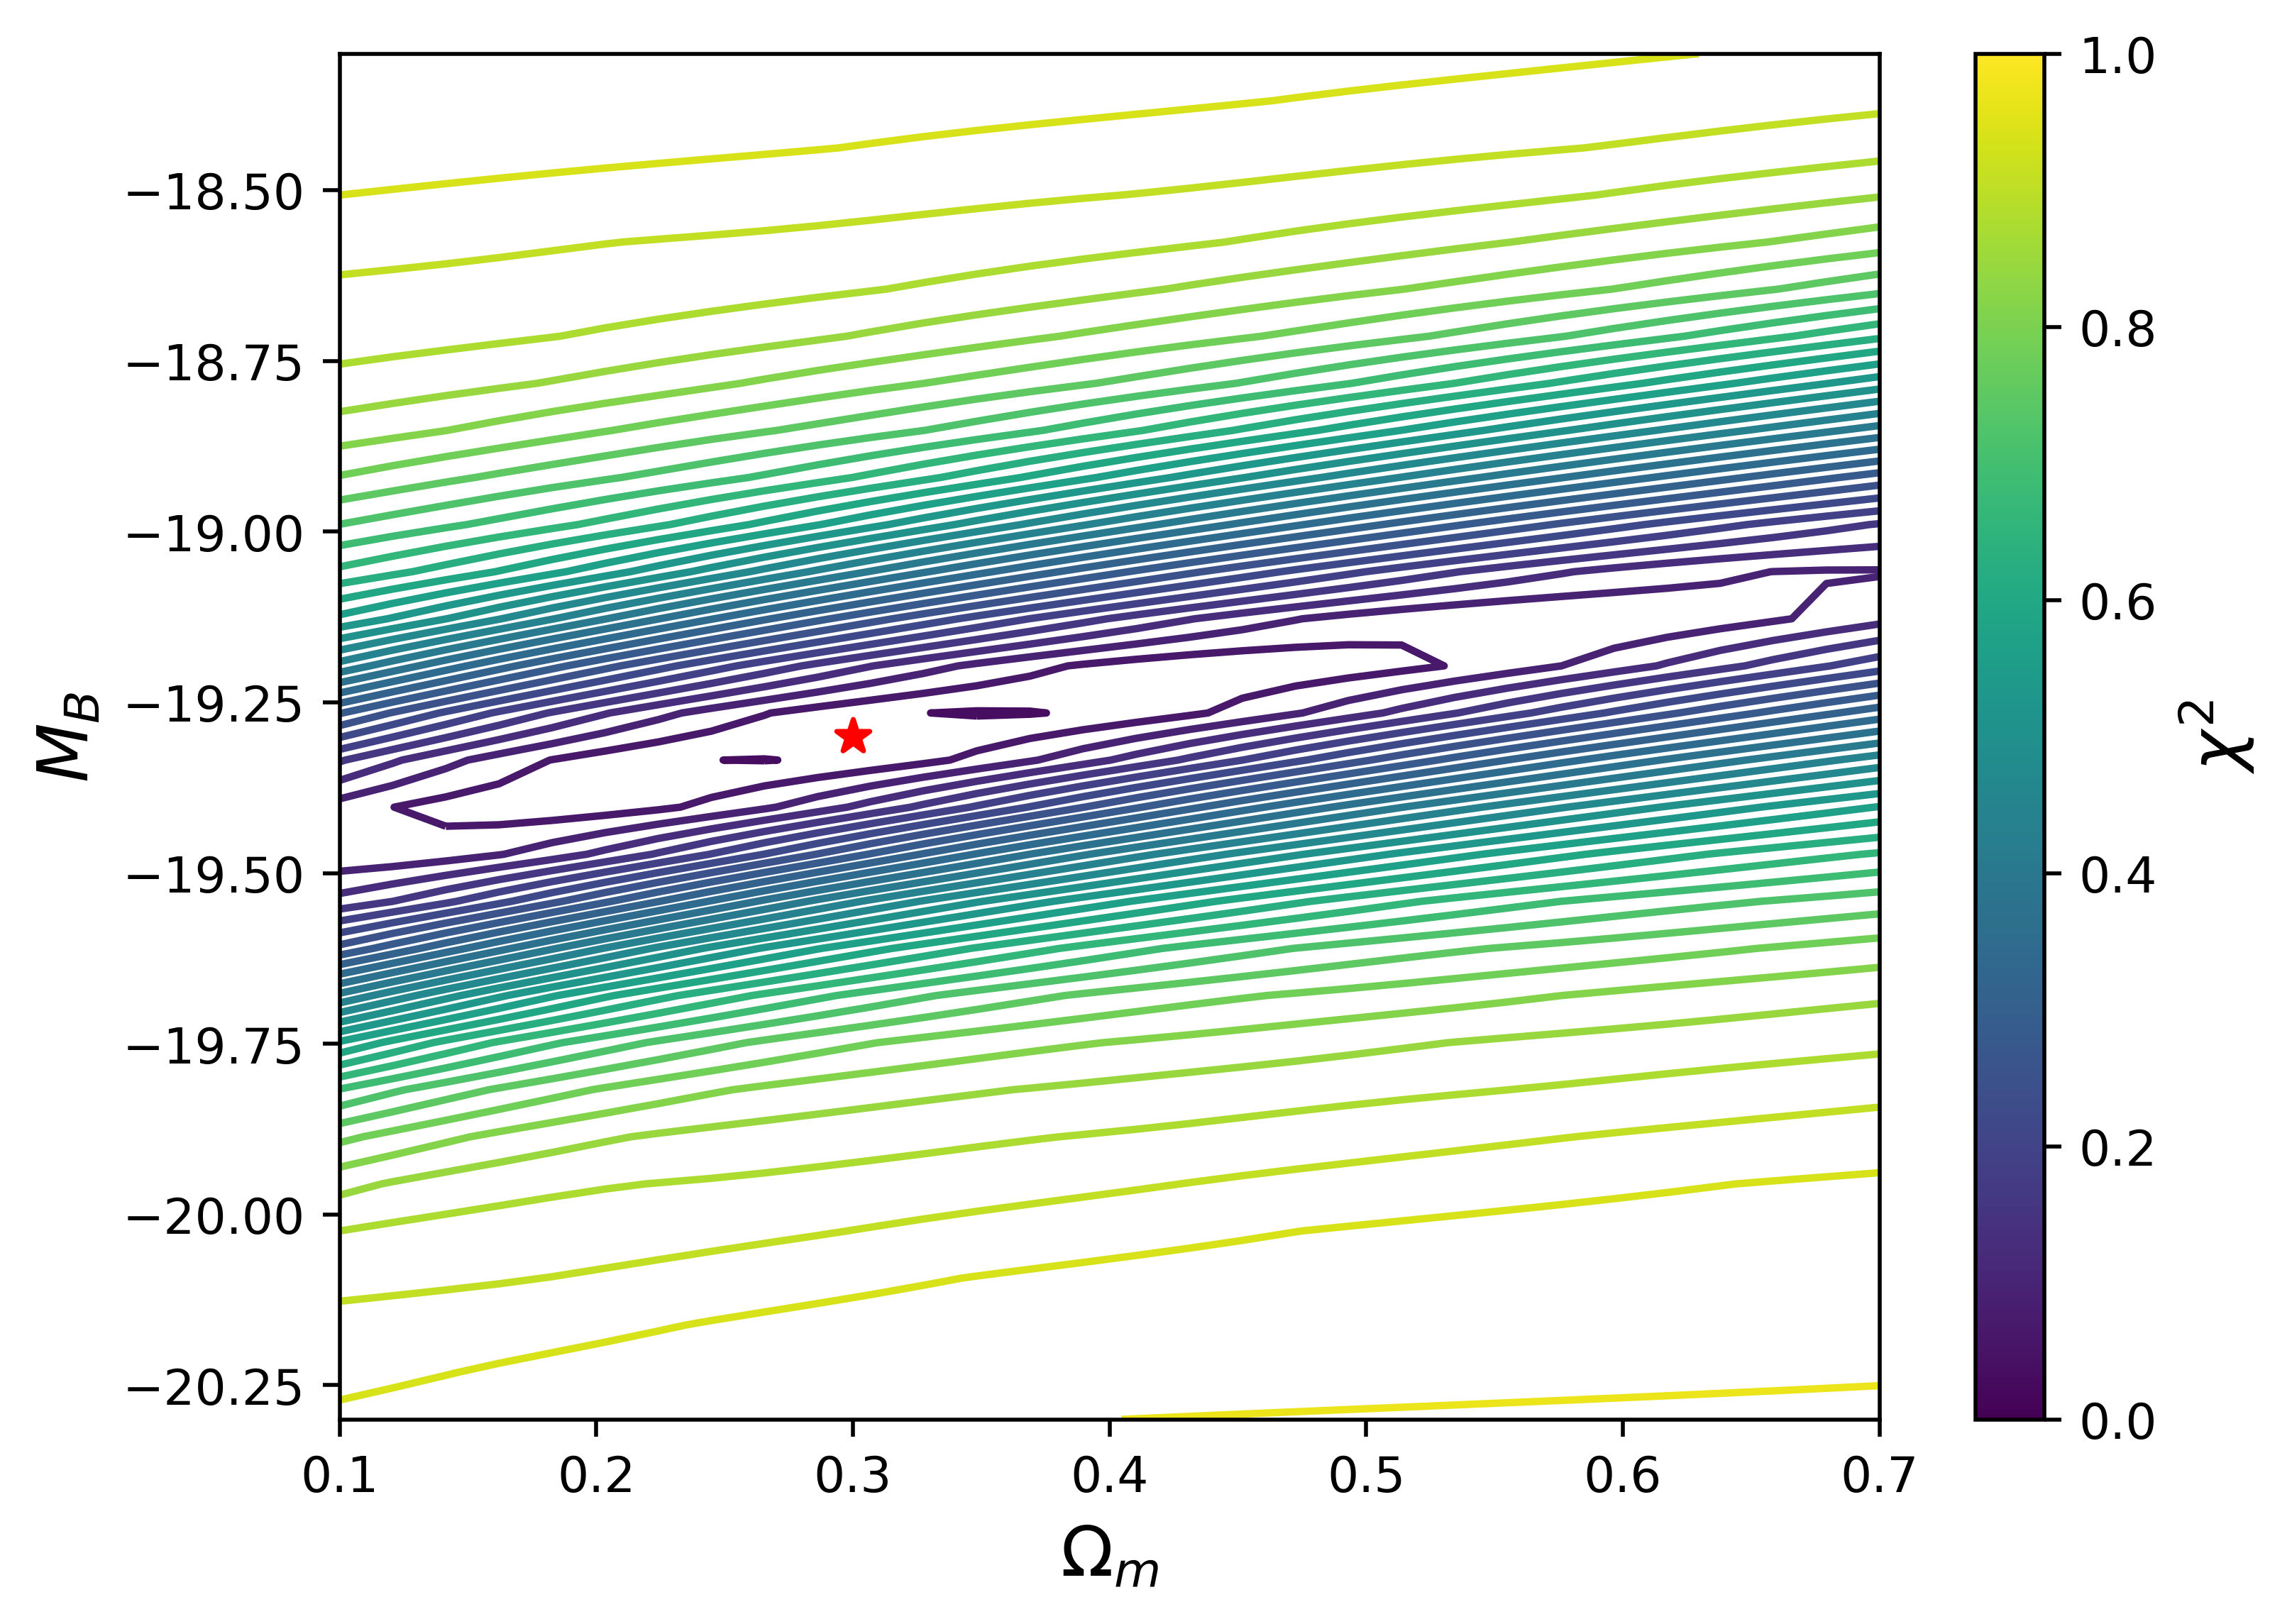

In [50]:
plt.contour(test_oms, test_MBs, chi2s, levels=30)
plt.scatter([0.3], [-19.3], c="r", marker="*", s=50)
cbar = plt.colorbar()
cbar.set_label(r"$\chi^2$"), plt.xlabel(r"$\Omega_m$"), plt.ylabel("$M_B$");

Alright, doesn't look too bad, our true point (the red star) is roughly the place of minimum $\chi^2$ value.

## Sampling the likelihood

Once again, we are turning to `emcee` to do the heavy lifting.

In [25]:
import emcee
ndim = 6  # How many parameters we are fitting. This is our dimensionality.
nwalkers = 20  # Keep this well above your dimensionality.
p0 = np.random.uniform(low=0.2, high=0.4, size=(nwalkers, ndim))  # Start points
p0 += np.array([0, -19, -0.1, -0.3, -0.1, 2.8])

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_log_posterior)
state = sampler.run_mcmc(p0, 2000)

In [32]:
chain = sampler.chain[:, 400:, :]
flat_chain = chain.reshape((-1, ndim))  # Stack the steps from each walker 

And with the samples on hand, lets throw them to ChainConsumer, to first confirm convergence of the walkers, and then check the posteriors.

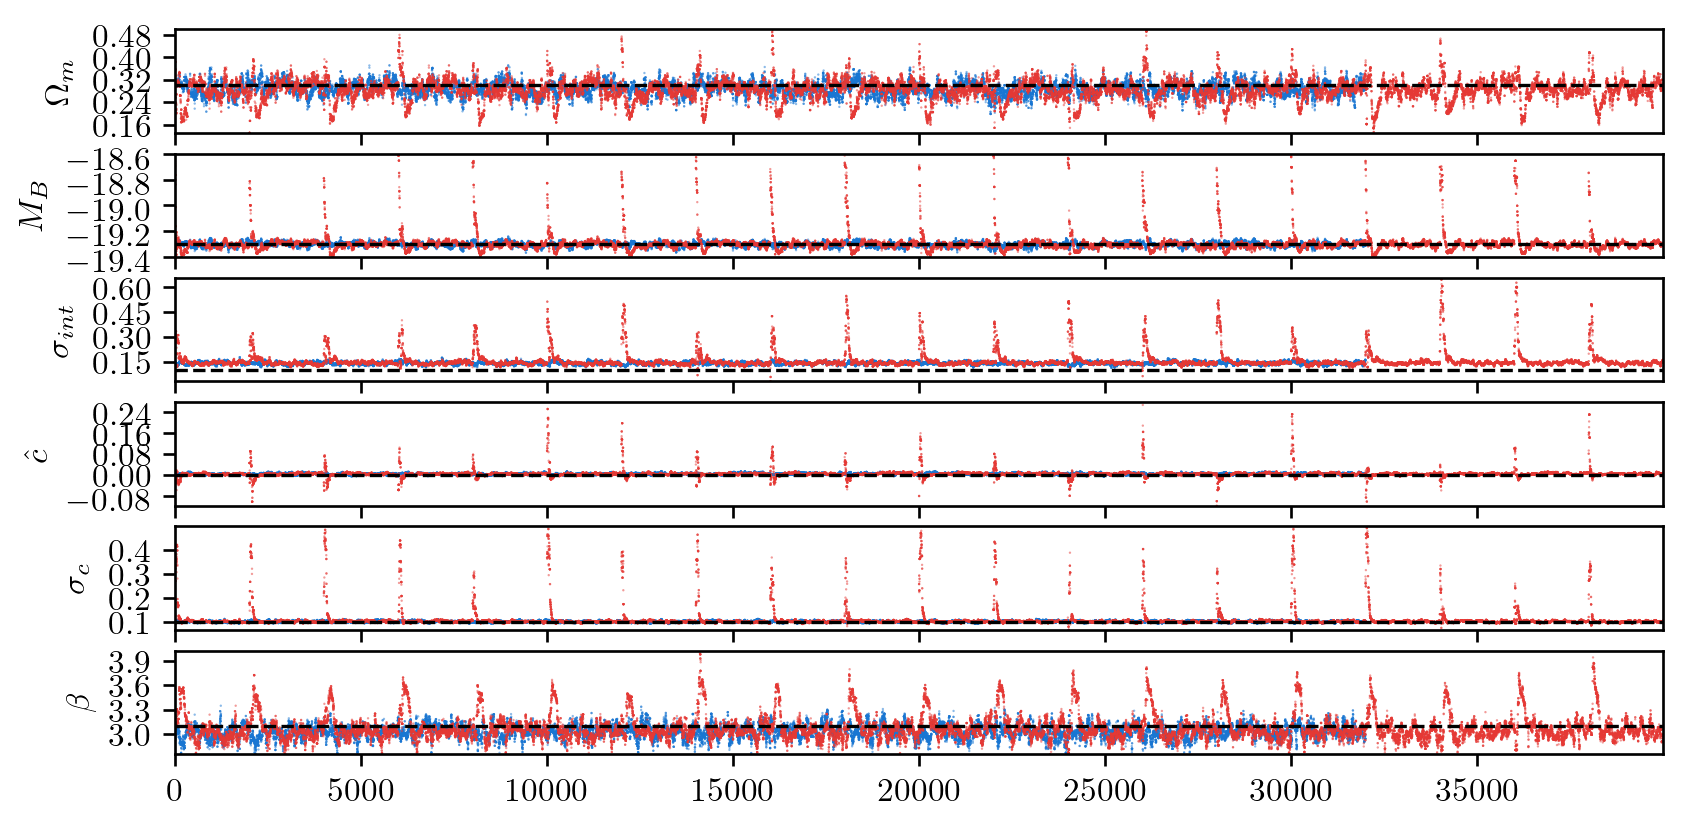

In [33]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
params = [r"$\Omega_m$", "$M_B$", r"$\sigma_{int}$", r"$\hat{c}$", r"$\sigma_c$", r"$\beta$"]
truth = [0.3, -19.3, 0.1, 0, 0.1, 3.1]
c.add_chain(flat_chain, parameters=params, color="b", kde=1.0)
c.add_chain(sampler.chain.reshape((-1, ndim)), color="r", kde=1.0)
c.plotter.plot_walks(truth=truth, figsize=(8,4));

Looks like they all converged quickly, let's go ahead and plot some contours.

$\Omega_m$ [0.2631903131008057, 0.29061597591154054, 0.30997425330717543]
$M_B$ [-19.321238731508483, -19.30171461622203, -19.288605748148946]
$\sigma_{int}$ [0.13493630624153524, 0.14197489565813534, 0.149863741561936]
$\hat{c}$ [0.0012303218508645198, 0.003937307331830951, 0.0069427817061358844]
$\sigma_c$ [0.09716341194044988, 0.09960155368306237, 0.10317454723851435]
$\beta$ [2.9498499986818523, 3.0479769146439795, 3.104881022084486]


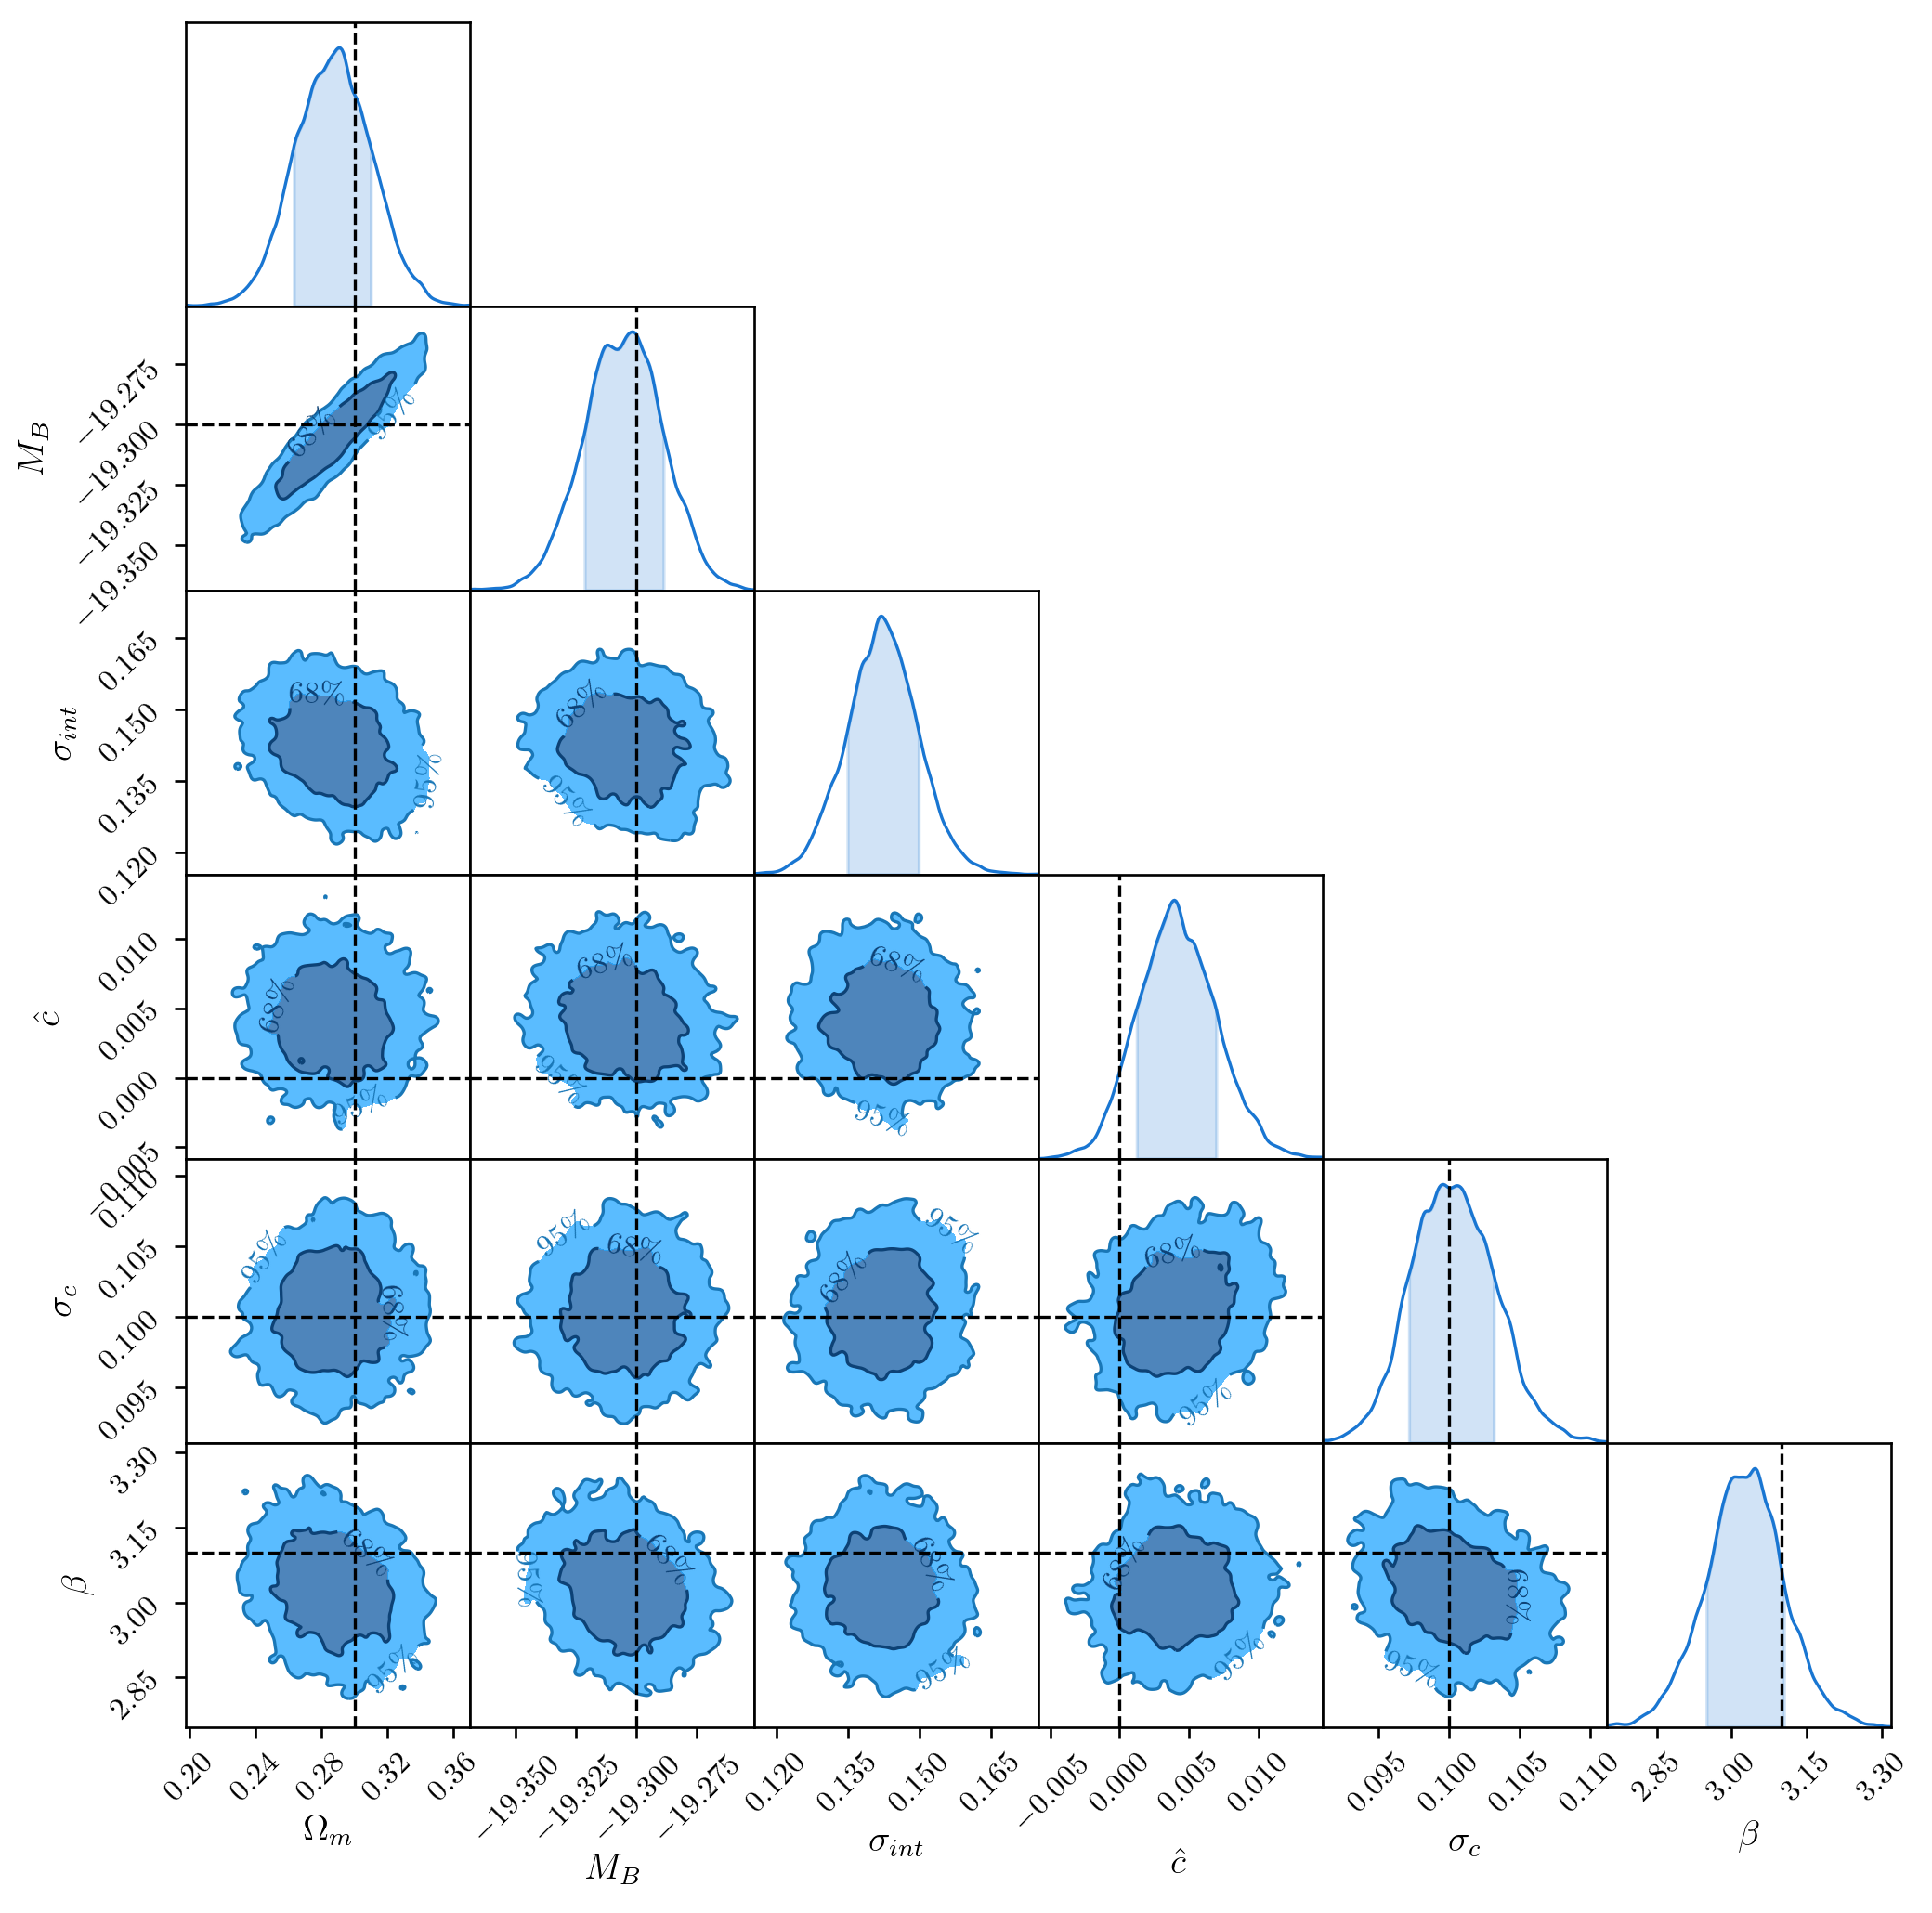

In [34]:
c = ChainConsumer()
c.add_chain(flat_chain, parameters=params)
c.configure(contour_labels="confidence")
c.plotter.plot(truth=truth, figsize=1.0)
summary = c.analysis.get_summary()
for key, value in summary.items():
    print(key, value)

Which looks pretty good for a first pass and proof of concept. We note the imperfect recovery of $\sigma_{int}$, which is a story as old as time for our field. Alas.